# World Happiness Report — Analysis
By: Adrian Chavez-Loya

This analysis explores the World Happiness Report, a global survey measuring the state of happiness across nations.  
The dataset ranks countries by their average life evaluation scores, derived from the Gallup World Poll, where respondents rate their lives on a scale from 0 (worst possible life) to 10 (best possible life).

The scores are influenced by six key factors:  
GDP per capita, social support, healthy life expectancy, freedom to make life choices, generosity, and perception of corruption. 
These variables help explain why some nations are happier than others, though they do not directly determine the total score.

The report, first published by the United Nations in 2012, has become a leading reference for understanding how *conomic, social, and institutional factors shape global well-being.  

This project analyzes data from 2015–2019, focusing on how happiness levels vary by region, evolve over time, and relate to key predictors such as wealth, health, and freedom.

**Data Source:** [World Happiness Report (Gallup World Poll)](https://www.kaggle.com/datasets/unsdsn/world-happiness)

In [15]:
# Package loading
# tidyverse: includes dplyr, ggplot2, purrr, etc.
# janitor: cleans messy column names (makes them lowercase_with_underscores)
# readr: for reading CSV files quickly
# stringr: for working with text and extracting years from filenames
# countrycode: for mapping countries to continents (I plan on using for the region field since I noticed difference in files)
library(tidyverse)
library(janitor)
library(readr)
library(stringr)
library(countrycode)


In [16]:
# Get list of CSVs in the folder
files <- list.files("world-happiness-report", pattern = "\\.csv$", full.names = TRUE)

# Loop through each file, clean, and combine into one data frame (df)
df <- map_dfr(files, function(path) {
  year <- str_extract(path, "\\d{4}") %>% as.integer()
  d <- read_csv(path, show_col_types = FALSE) %>% clean_names()
  # Harmonize column names based on year
  d <- if (year <= 2017) {
    d %>%
      transmute(
        year = year,
        country = country,
        region = if ("region" %in% names(.)) region else NA_character_,
        rank = happiness_rank,
        score = happiness_score,
        gdp = economy_gdp_per_capita,
        social_support = family,
        health = health_life_expectancy,
        freedom = freedom,
        generosity = generosity,
        corruption = trust_government_corruption
      )
  } else {
    d %>%
      transmute(
        year = year,
        country = country_or_region,
        region = NA_character_,
        rank = overall_rank,
        score = score,
        gdp = gdp_per_capita,
        social_support = social_support,
        health = healthy_life_expectancy,
        freedom = freedom_to_make_life_choices,
        generosity = generosity,
        corruption = perceptions_of_corruption
      )
  }

  # Ensure all numeric columns are truly numeric (handles “N/A” etc.)
  d %>% mutate(across(c(rank, score, gdp, social_support, health, freedom, generosity, corruption),
                      ~ readr::parse_number(as.character(.))))
})


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(...)`.
Caused by warning:
! 1 parsing failure.
row col expected actual
 20  -- a number    N/A”


In [18]:
df <- df %>%
  mutate(
    # Fill continent automatically; fix Kosovo manually since it doesn't have mapping
    region = coalesce(region, countrycode(country, "country.name", "continent")),
    region = if_else(country == "Kosovo", "Europe", region)
  ) %>%
  arrange(country, year) %>%
  group_by(country) %>%
  mutate(
    rank_change  = rank - lag(rank),
    score_change = score - lag(score)
  ) %>%
  ungroup()


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `region = coalesce(region, countrycode(country, "country.name",
  "continent"))`.
Caused by warning:
! Some values were not matched unambiguously: Kosovo”


In [19]:
# Re-calculate rank for any missing values within each year, ranking by descending happiness score.
df <- df %>%
  group_by(year) %>%
  mutate(rank = coalesce(rank, min_rank(desc(score)))) %>%
  ungroup()


In [21]:
# View of df structure
glimpse(df)
# Count number of records per year (should show 2015–2019)
df %>% count(year)
# Check % of missing values per main numeric column
df %>% summarise(across(c(score, gdp, social_support, health, freedom, generosity, corruption),
                        ~mean(is.na(.))*100))

# Note: the NA values for rank and score change come from using 'lag' comparison and there not being a previous year to compare to!


Rows: 782
Columns: 13
$ year           <int> 2015, 2016, 2017, 2018, 2019, 2015, 2016, 2017, 2018, 2…
$ country        <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanist…
$ region         <chr> "Southern Asia", "Southern Asia", "Asia", "Asia", "Asia…
$ rank           <dbl> 153, 154, 141, 145, 154, 95, 109, 109, 112, 107, 68, 38…
$ score          <dbl> 3.575, 3.360, 3.794, 3.632, 3.203, 4.959, 4.655, 4.644,…
$ gdp            <dbl> 0.3198200, 0.3822700, 0.4014772, 0.3320000, 0.3500000, …
$ social_support <dbl> 0.3028500, 0.1103700, 0.5815433, 0.5370000, 0.5170000, …
$ health         <dbl> 0.30335000, 0.17344000, 0.18074678, 0.25500000, 0.36100…
$ freedom        <dbl> 0.2341400, 0.1643000, 0.1061795, 0.0850000, 0.0000000, …
$ generosity     <dbl> 0.36510000, 0.31268000, 0.31187093, 0.19100000, 0.15800…
$ corruption     <dbl> 0.09719000, 0.07112000, 0.06115783, 0.03600000, 0.02500…
$ rank_change    <dbl> NA, 1, -13, 4, 9, NA, 14, 0, 3, -5, NA, -30, 15, 31, 4,…
$ score_change   <

year,n
<int>,<int>
2015,158
2016,157
2017,155
2018,156
2019,156


score,gdp,social_support,health,freedom,generosity,corruption
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0.1278772


In [22]:
# Create CSV of our df which we will use for analysis further in Tableau!
write_csv(df, "cleaned_world_happiness_2015_2019.csv")


## Global and Regional Happiness Analysis

### Global Happiness Trend (2015–2019)

# A tibble: 5 × 2
   year global_avg_score
  <int>            <dbl>
1  2015             5.38
2  2016             5.38
3  2017             5.35
4  2018             5.38
5  2019             5.41


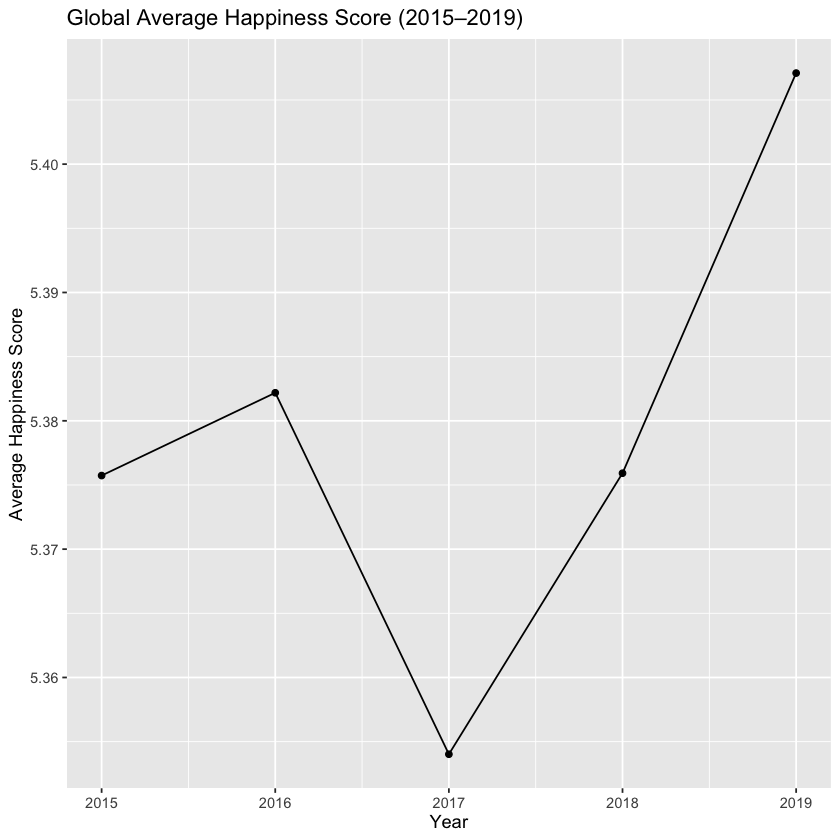

In [23]:
# Global average happiness per year
global_trend <- df %>%
  group_by(year) %>%
  summarize(global_avg_score = mean(score, na.rm = TRUE)) %>%
  arrange(year)

print(global_trend)

p_global_trend <- ggplot(global_trend, aes(x = year, y = global_avg_score)) +
  geom_line() +
  geom_point() +
  labs(
    title = "Global Average Happiness Score (2015–2019)",
    x = "Year",
    y = "Average Happiness Score"
  )

print(p_global_trend)


| Year | Avg. Happiness Score |
|------|----------------------|
| 2015 | 5.38 |
| 2016 | 5.38 |
| 2017 | 5.35 |
| 2018 | 5.38 |
| 2019 | 5.41 |

Global happiness remained stable around 5.37 from 2015–2018, with a slight rise to 5.41 in 2019.  
Overall, the world’s average happiness level showed minimal change but a small upward trend by the end of the period.
**It looks like the world was getting happier before the pandemic.**


### Regional Happiness Trends (2015–2019)

# A tibble: 15 × 3
   region                      year avg_score
   <chr>                      <int>     <dbl>
 1 Africa                      2017      4.24
 2 Africa                      2018      4.29
 3 Africa                      2019      4.37
 4 Americas                    2017      6.06
 5 Americas                    2018      6.05
 6 Americas                    2019      6.05
 7 Asia                        2017      5.30
 8 Asia                        2018      5.27
 9 Asia                        2019      5.27
10 Australia and New Zealand   2015      7.28
11 Australia and New Zealand   2016      7.32
12 Central and Eastern Europe  2015      5.32
13 Central and Eastern Europe  2016      5.37
14 Eastern Asia                2015      5.63
15 Eastern Asia                2016      5.62


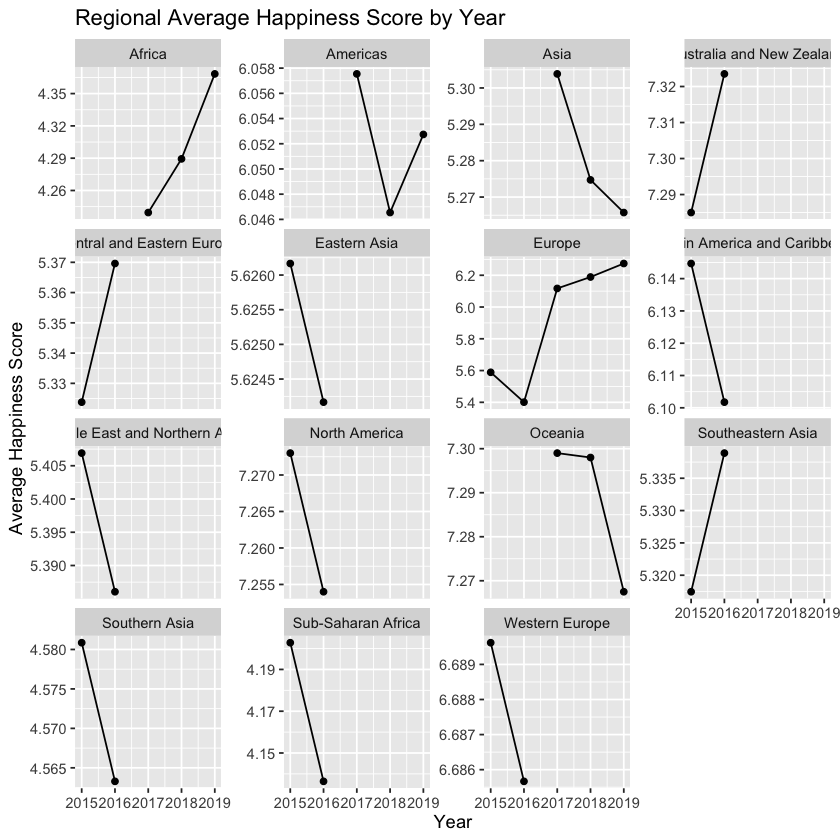

In [26]:
# Regional average happiness per year (line chart)
regional_trend <- df %>%
  group_by(region, year) %>%
  summarize(avg_score = mean(score, na.rm = TRUE), .groups = "drop") %>%
  arrange(region, year)

print(head(regional_trend, 15))

p_regional_trend <- ggplot(regional_trend, aes(x = year, y = avg_score, group = region)) +
  geom_line() +
  geom_point() +
  facet_wrap(~ region, scales = "free_y") +
  labs(
    title = "Regional Average Happiness Score by Year",
    x = "Year",
    y = "Average Happiness Score"
  )

print(p_regional_trend)

### Happiness Distribution by Region (2019)

# A tibble: 5 × 4
  region   mean_score median_score     n
  <chr>         <dbl>        <dbl> <int>
1 Oceania        7.27         7.27     2
2 Europe         6.27         6.17    40
3 Americas       6.05         6.12    23
4 Asia           5.27         5.25    46
5 Africa         4.37         4.46    45


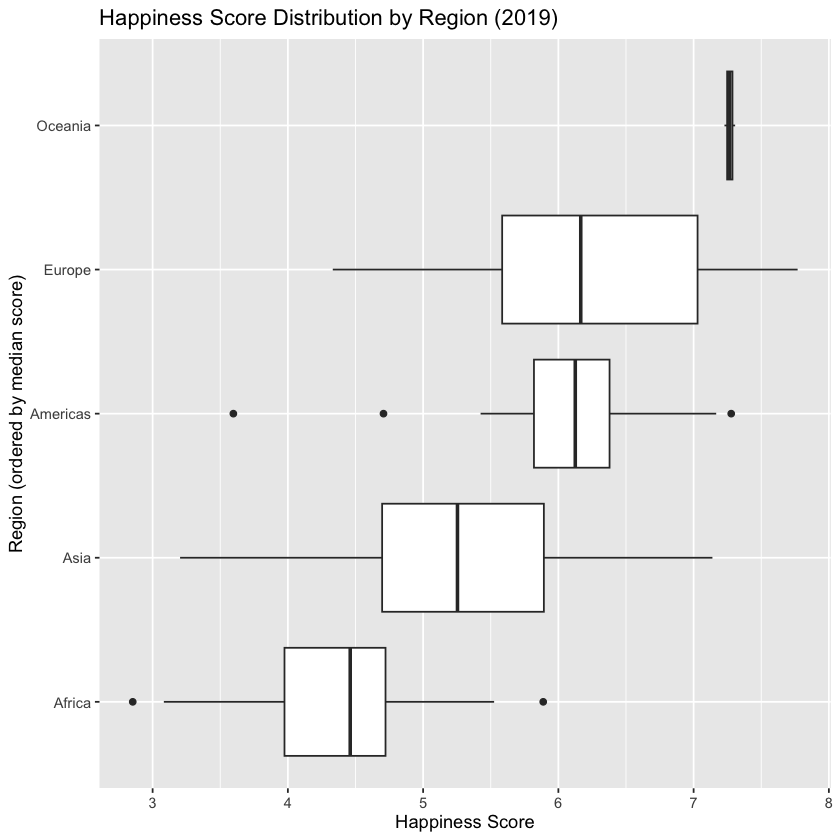

In [27]:
# Regional distribution (boxplot, latest year only)
latest_year <- max(df$year, na.rm = TRUE)

regional_box_latest <- df %>%
  filter(year == latest_year) %>%
  group_by(region) %>%
  summarize(
    mean_score = mean(score, na.rm = TRUE),
    median_score = median(score, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  arrange(desc(mean_score))

print(regional_box_latest)

p_regional_box <- df %>%
  filter(year == latest_year) %>%
  ggplot(aes(x = reorder(region, score, FUN = median), y = score)) +
  geom_boxplot() +
  coord_flip() +
  labs(
    title = paste0("Happiness Score Distribution by Region (", latest_year, ")"),
    x = "Region (ordered by median score)",
    y = "Happiness Score"
  )

print(p_regional_box)

| Rank | Region | Mean Score | Median | Countries |
|------|---------|-------------|---------|------------|
| 1 | Oceania | 7.27 | 7.27 | 2 |
| 2 | Europe | 6.27 | 6.17 | 40 |
| 3 | Americas | 6.05 | 6.12 | 23 |
| 4 | Asia | 5.27 | 5.25 | 46 |
| 5 | Africa | 4.37 | 4.46 | 45 |

Oceania is the happiest region, followed by Europe and the Americas.  
Asia ranks fourth, and Africa is the least happy region. 

Now lets analyze countries individually!

## Happiness by Country Comparison

### Top 10 and Bottom 10 countries in the most recent year (2019)

In [28]:
latest_year <- max(df$year, na.rm = TRUE)

top10 <- df %>%
  filter(year == latest_year) %>%
  arrange(desc(score)) %>%
  slice_head(n = 10) %>%
  select(country, region, score, rank)

bottom10 <- df %>%
  filter(year == latest_year) %>%
  arrange(score) %>%
  slice_head(n = 10) %>%
  select(country, region, score, rank)

print(top10)
print(bottom10)

# A tibble: 10 × 4
   country     region   score  rank
   <chr>       <chr>    <dbl> <dbl>
 1 Finland     Europe    7.77     1
 2 Denmark     Europe    7.6      2
 3 Norway      Europe    7.55     3
 4 Iceland     Europe    7.49     4
 5 Netherlands Europe    7.49     5
 6 Switzerland Europe    7.48     6
 7 Sweden      Europe    7.34     7
 8 New Zealand Oceania   7.31     8
 9 Canada      Americas  7.28     9
10 Austria     Europe    7.25    10
# A tibble: 10 × 4
   country                  region   score  rank
   <chr>                    <chr>    <dbl> <dbl>
 1 South Sudan              Africa    2.85   156
 2 Central African Republic Africa    3.08   155
 3 Afghanistan              Asia      3.20   154
 4 Tanzania                 Africa    3.23   153
 5 Rwanda                   Africa    3.33   152
 6 Yemen                    Asia      3.38   151
 7 Malawi                   Africa    3.41   150
 8 Syria                    Asia      3.46   149
 9 Botswana                 Africa    3.

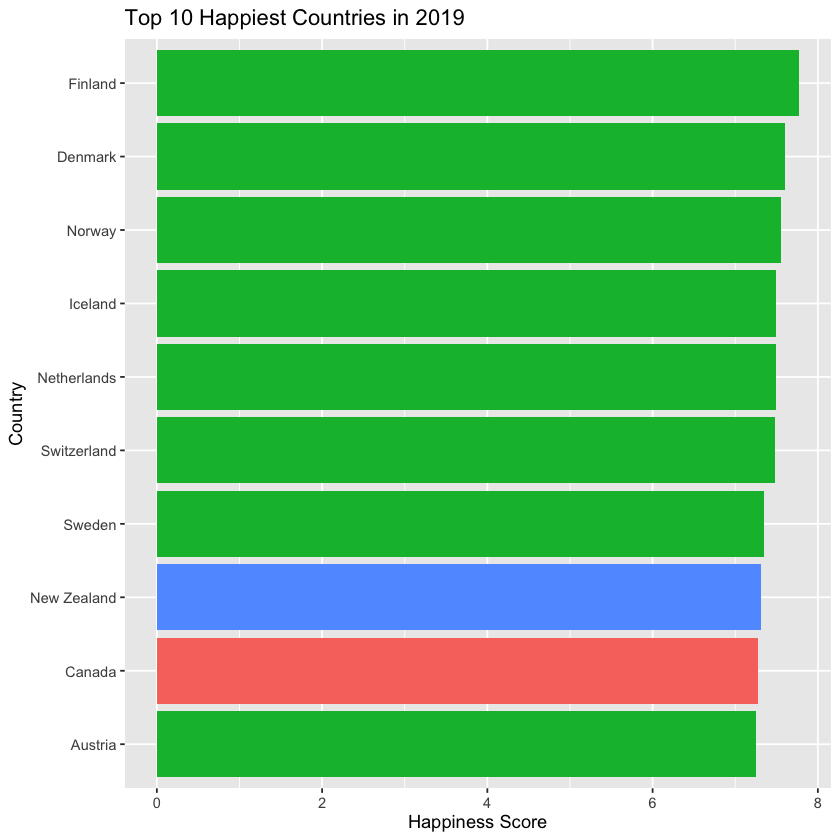

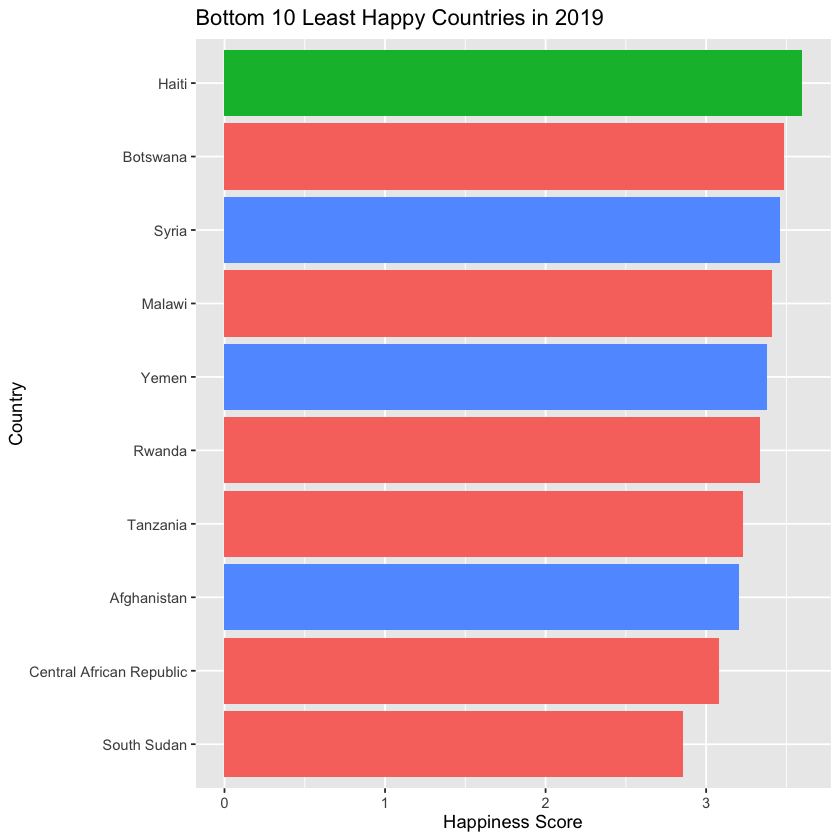

In [33]:
# Visualizations of top 10 and our bottom 10 happiest countries
p_top10 <- ggplot(top10, aes(x = reorder(country, score), y = score, fill = region)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  labs(
    title = paste("Top 10 Happiest Countries in", latest_year),
    x = "Country",
    y = "Happiness Score"
  )

p_bottom10 <- ggplot(bottom10, aes(x = reorder(country, score), y = score, fill = region)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  labs(
    title = paste("Bottom 10 Least Happy Countries in", latest_year),
    x = "Country",
    y = "Happiness Score"
  )

print(p_top10)
print(p_bottom10)


#### Happiest and Saddest Countries
- Nordic countries dominate the top 10 - led by Finland.  
- The lowest scores are concentrated in Africa and conflict-affected regions of Asia.

###  Largest positive and negative movers (2015–2019)

In [29]:
movers <- df %>%
  filter(year %in% c(2015, 2019)) %>%
  select(country, year, rank, score) %>%
  pivot_wider(names_from = year, values_from = c(rank, score), names_prefix = "y") %>%
  mutate(
    rank_change_total = rank_y2019 - rank_y2015,
    score_change_total = score_y2019 - score_y2015
  )

top_improvers <- movers %>%
  arrange(rank_change_total) %>% # negative means rank improved (1 is best)
  slice_head(n = 10) %>%
  select(country, rank_change_total, score_change_total)

top_decliners <- movers %>%
  arrange(desc(rank_change_total)) %>%
  slice_head(n = 10) %>%
  select(country, rank_change_total, score_change_total)

print(top_improvers)
print(top_decliners)


# A tibble: 10 × 3
   country      rank_change_total score_change_total
   <chr>                    <dbl>              <dbl>
 1 Benin                      -53              1.54 
 2 Ivory Coast                -52              1.29 
 3 Honduras                   -46              1.07 
 4 Hungary                    -42              0.958
 5 Gabon                      -39              0.903
 6 Romania                    -38              0.946
 7 Bulgaria                   -37              0.793
 8 Burkina Faso               -37              1    
 9 Cameroon                   -37              0.792
10 Cambodia                   -36              0.881
# A tibble: 10 × 3
   country    rank_change_total score_change_total
   <chr>                  <dbl>              <dbl>
 1 Venezuela                 85             -2.10 
 2 Zambia                    53             -1.02 
 3 Lesotho                   47             -1.10 
 4 Swaziland                 34             -0.655
 5 Zimbabwe         

### Visualizations (Top, Bottom, Movers)

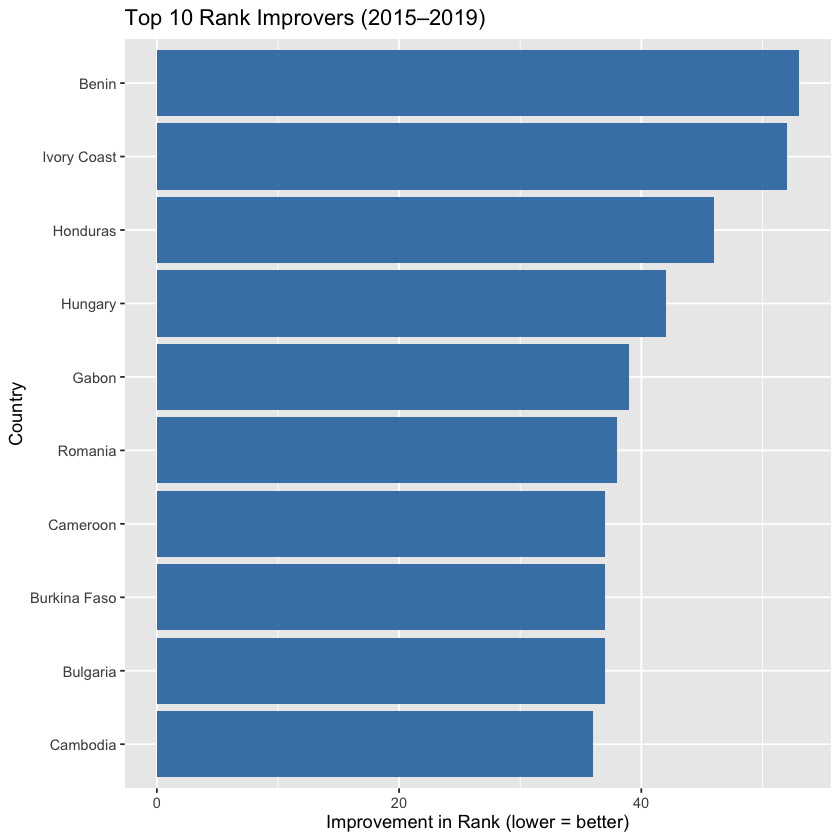

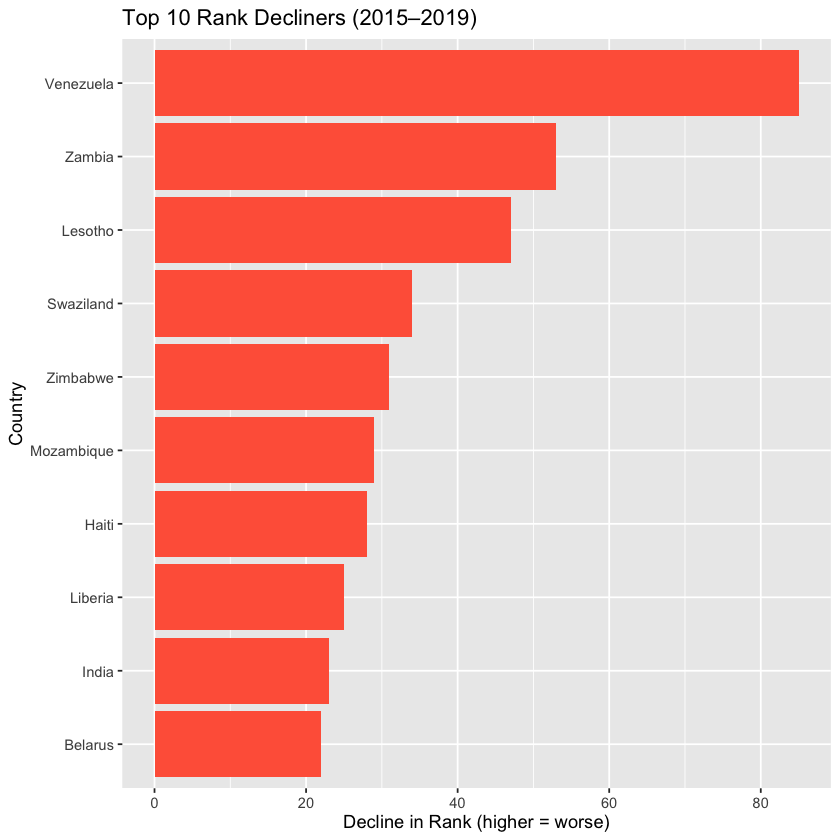

In [34]:
p_top_movers <- ggplot(top_improvers, aes(x = reorder(country, -rank_change_total), y = -rank_change_total)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Top 10 Rank Improvers (2015–2019)",
    x = "Country",
    y = "Improvement in Rank (lower = better)"
  )

p_bottom_movers <- ggplot(top_decliners, aes(x = reorder(country, rank_change_total), y = rank_change_total)) +
  geom_col(fill = "tomato") +
  coord_flip() +
  labs(
    title = "Top 10 Rank Decliners (2015–2019)",
    x = "Country",
    y = "Decline in Rank (higher = worse)"
  )

print(p_top_movers)
print(p_bottom_movers)

#### Top 10 Movers and Decliners
- Benin and Ivory Coast saw the largest improvements in happiness since 2015
- Venezuela experienced the sharpest decline globally.

## Factors Influencing Happiness

### Compute correlations (2019 only)

In [35]:
latest_year <- max(df$year, na.rm = TRUE)

corr_data <- df %>%
  filter(year == latest_year) %>%
  select(score, gdp, social_support, health, freedom, generosity, corruption)

cor_matrix <- cor(corr_data, use = "complete.obs")

print(round(cor_matrix, 2))

               score   gdp social_support health freedom generosity corruption
score           1.00  0.79           0.78   0.78    0.57       0.08       0.39
gdp             0.79  1.00           0.75   0.84    0.38      -0.08       0.30
social_support  0.78  0.75           1.00   0.72    0.45      -0.05       0.18
health          0.78  0.84           0.72   1.00    0.39      -0.03       0.30
freedom         0.57  0.38           0.45   0.39    1.00       0.27       0.44
generosity      0.08 -0.08          -0.05  -0.03    0.27       1.00       0.33
corruption      0.39  0.30           0.18   0.30    0.44       0.33       1.00


#### Factors Influencing Happiness
- **GDP, social support, and health** have the **strongest** positive correlations with happiness (~0.78–0.79).  
- **Freedom** also shows a **moderate positive relationship** (0.57).  
- Corruption perception has a weaker but positive link (0.39) and shows view of government is important to some extent.
- Generosity is only weakly correlated (0.08), suggesting suprisingly minimal impact.  
- Overall, ***economic strength, health, and social bonds are the key drivers of happiness.***

### Correlation Heatmap


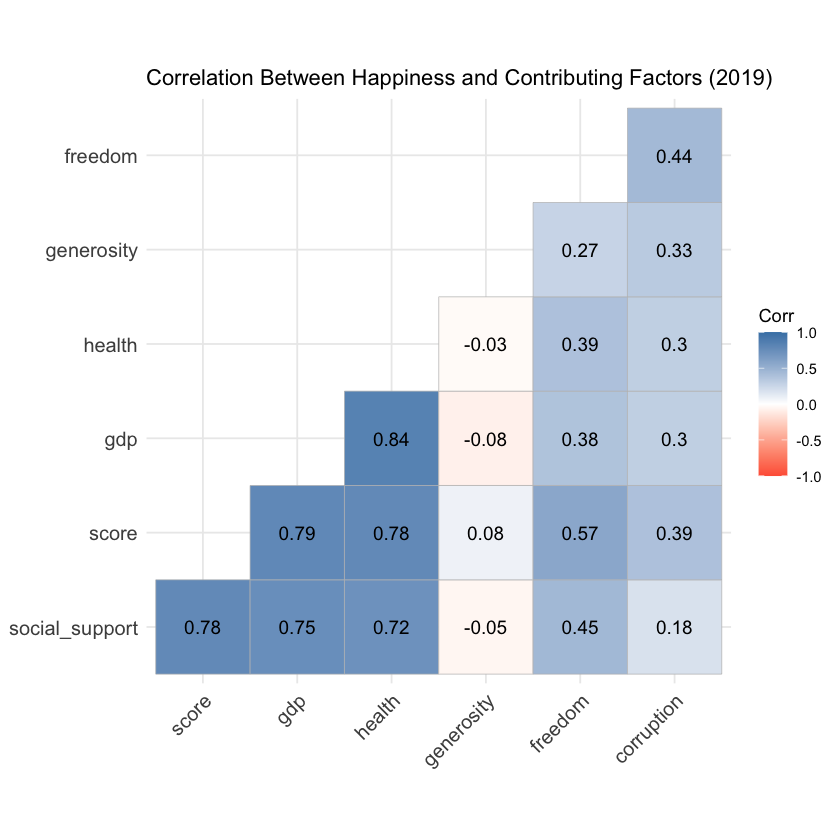

In [39]:
library(ggcorrplot)
ggcorrplot(
  cor_matrix,
  lab = TRUE,
  hc.order = TRUE,
  type = "lower",
  colors = c("tomato", "white", "steelblue"),
  title = "Correlation Between Happiness and Contributing Factors (2019)"
)

#### Correlation Between Happiness and Contributing Factors (2019)
- GDP, health, and social support show the strongest relationships with happiness.  
- Freedom has a moderate positive effect, while generosity is weakly related.  
- Corruption perception is mildly positive — countries with lower corruption tend to be happier overall! 


### Key scatter plots for strongest relationships (GDP vs Happiness)

`geom_smooth()` using formula = 'y ~ x'


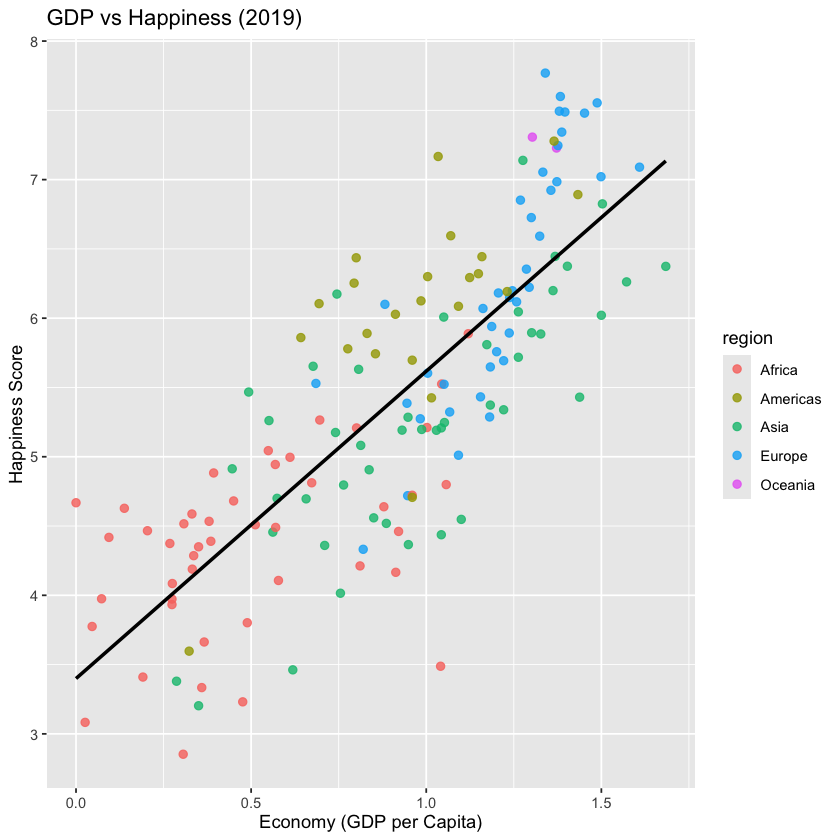

In [42]:
p_gdp <- ggplot(df %>% filter(year == latest_year),
                aes(x = gdp, y = score, color = region)) +
  geom_point(size = 2, alpha = 0.8) +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "GDP vs Happiness (2019)",
       x = "Economy (GDP per Capita)",
       y = "Happiness Score")

print(p_gdp)

#### GDP vs Happiness (2019)
- Countries with higher GDP per capita tend to have higher happiness scores.  
- The relationship is strong and consistent across regions (especially in Europe and Oceania) it seems
- Lower-income regions such as Africa cluster toward lower happiness levels and are not as linear

### Social Support vs Happiness

`geom_smooth()` using formula = 'y ~ x'


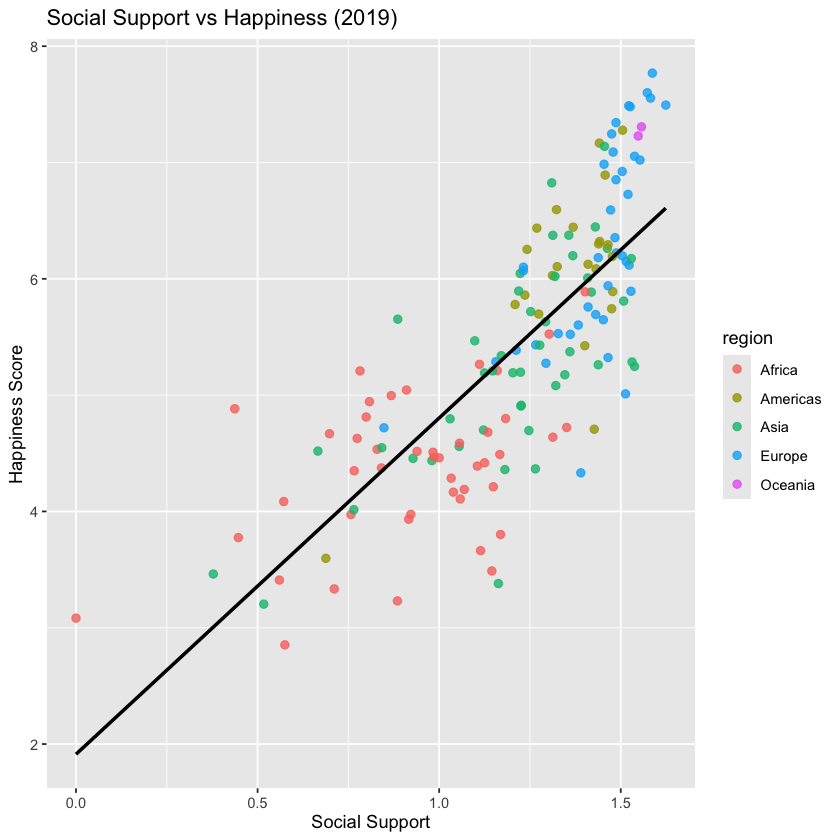

In [44]:
p_social <- ggplot(df %>% filter(year == latest_year),
                   aes(x = social_support, y = score, color = region)) +
  geom_point(size = 2, alpha = 0.8) +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "Social Support vs Happiness (2019)",
       x = "Social Support",
       y = "Happiness Score")

print(p_social)

#### Social Support vs Happiness (2019)
- Strong positive relationship between social support and happiness.  
- Countries with higher levels of community and family support report much greater happiness.  
- Top-scoring regions like Europe and Oceania show the tightest clustering at high social support levels.

### Health vs Happiness

`geom_smooth()` using formula = 'y ~ x'


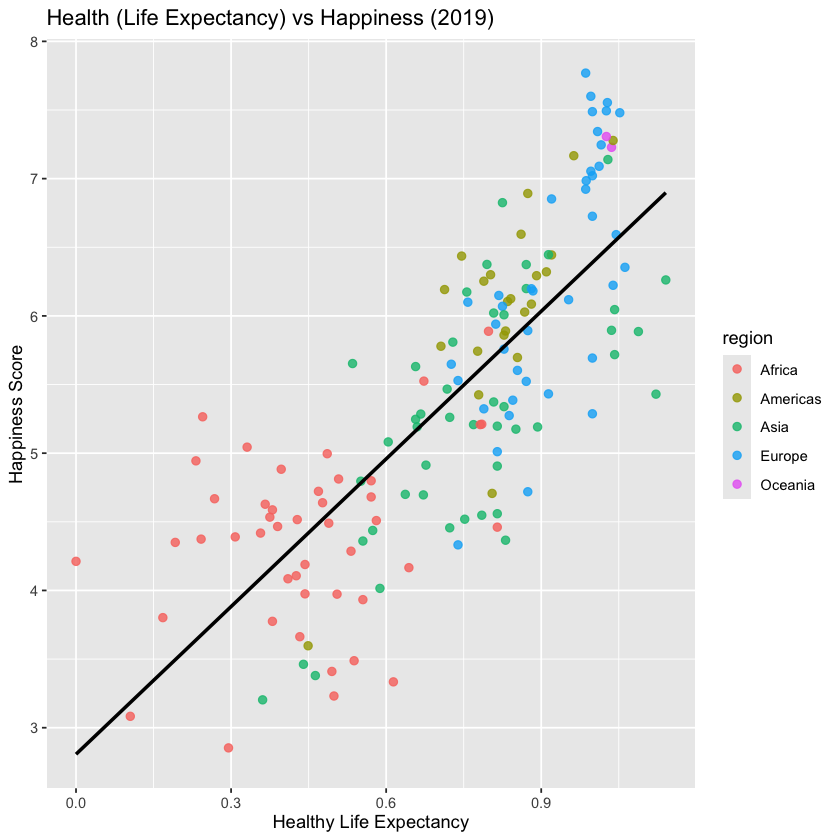

In [45]:
p_health <- ggplot(df %>% filter(year == latest_year),
                   aes(x = health, y = score, color = region)) +
  geom_point(size = 2, alpha = 0.8) +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "Health (Life Expectancy) vs Happiness (2019)",
       x = "Healthy Life Expectancy",
       y = "Happiness Score")

print(p_health)

#### Health (Life Expectancy) vs Happiness (2019)
- Clear positive trend: countries with longer healthy life expectancy report higher happiness!
- Healthier populations in Europe and Oceania tend to cluster at the top of the happiness scale.  
- Nations with lower life expectancy, mainly in Africa, correspond to the lowest happiness scores.
---


## Summary of Key Findings (2015–2019)

- **Global happiness remained relatively stable**, averaging around 5.35–5.4.  
  While the overall trend didn’t change much, **individual countries shifted significantly in rank**.

- **Oceania (Australia & New Zealand) consistently led as the happiest region**, followed by **Europe and the Americas**.  
  Asia showed mixed outcomes, and **Africa remained the lowest on average**.

- **The Nordic countries—Finland, Denmark, Norway, Iceland, and the Netherlands—dominated the top ranks**,  
  while **nations affected by conflict or instability (e.g., South Sudan, Afghanistan, Yemen) stayed at the bottom**.

- **Benin and Ivory Coast showed the greatest improvements since 2015**,  
  whereas **Venezuela saw the steepest decline due to economic and social turmoil**.

- Across all years, **GDP, social support, and health were the strongest drivers of happiness**.  
  Freedom had a moderate impact, while **generosity and corruption perception were weaker influences**.

- Regression confirmed that **freedom, social support, and health contribute most to happiness**,  
  reinforcing that **both economic stability and social well-being are essential for life satisfaction**.

  In short, **the happiest countries combine wealth, health, trust, and freedom**, while **nations facing economic hardship or instability continue to lag behind**.
---

## Further Data Preparation for Tableau Analysis
We will now prepare our data and modify it so it will be easier to analyze further in Tableau!

In [47]:
# Step 1: We will add ISO3 country codes for Tableau’s mapping compatibility
df <- df %>%
  mutate(iso3 = countrycode(country, "country.name", "iso3c"))

# Quick check
df %>% select(country, iso3) %>% head()


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `iso3 = countrycode(country, "country.name", "iso3c")`.
Caused by warning:
! Some values were not matched unambiguously: Kosovo, Somaliland region, Somaliland Region”


country,iso3
<chr>,<chr>
Afghanistan,AFG
Afghanistan,AFG
Afghanistan,AFG
Afghanistan,AFG
Afghanistan,AFG
Albania,ALB


We got an error as expected with Kosovo, and some other regions also need to be manually mapped. Let's do that very quickly.

In [48]:
# Fix unmatched or ambiguous ISO3 codes (e.g., Kosovo, Somaliland)
df <- df %>%
  mutate(
    iso3 = case_when(
      country == "Kosovo" ~ "XKX",
      str_detect(country, "Somaliland") ~ "SML",
      TRUE ~ iso3
    )
  )

# Quick check
df %>% select(country, iso3) %>% head()

country,iso3
<chr>,<chr>
Afghanistan,AFG
Afghanistan,AFG
Afghanistan,AFG
Afghanistan,AFG
Afghanistan,AFG
Albania,ALB


In [49]:
# Step 2: Calculate year-over-year change for key factors
# This lets us visualize improvement or decline in happiness drivers in Tableau later
df <- df %>%
  group_by(country) %>%
  arrange(year, .by_group = TRUE) %>%
  mutate(
    gdp_change = gdp - lag(gdp),
    social_support_change = social_support - lag(social_support),
    health_change = health - lag(health),
    freedom_change = freedom - lag(freedom),
    generosity_change = generosity - lag(generosity),
    corruption_change = corruption - lag(corruption)
  ) %>%
  ungroup()

# Verify with a sample
df %>% filter(country == "Finland") %>%
  select(year, score, gdp_change, health_change, freedom_change)


year,score,gdp_change,health_change,freedom_change
<int>,<dbl>,<dbl>,<dbl>,<dbl>
2015,7.406,NA,NA,NA
2016,7.413,0.11573000,-0.07820000,-0.07065000
2017,7.469,0.03759193,-0.00175233,0.04691086
2018,7.632,-0.13857193,0.06484233,0.06304914
2019,7.769,0.03500000,0.11200000,-0.08500000


In [50]:
# Step 3: Summarize average metrics per country for 2015–2019
country_summary <- df %>%
  group_by(country, region, iso3) %>%
  summarise(
    avg_score = mean(score, na.rm = TRUE),
    avg_gdp = mean(gdp, na.rm = TRUE),
    avg_social_support = mean(social_support, na.rm = TRUE),
    avg_health = mean(health, na.rm = TRUE),
    avg_freedom = mean(freedom, na.rm = TRUE),
    avg_generosity = mean(generosity, na.rm = TRUE),
    avg_corruption = mean(corruption, na.rm = TRUE),
    total_rank_change = sum(rank_change, na.rm = TRUE),
    total_score_change = sum(score_change, na.rm = TRUE)
  ) %>%
  arrange(desc(avg_score))


`summarise()` has grouped output by 'country', 'region'. You can override using
the `.groups` argument.


In [51]:
# Step 4: Run regression to see which factors most influence happiness
df_2019 <- df %>% filter(year == 2019)

model_2019 <- lm(score ~ gdp + social_support + health + freedom + generosity + corruption, data = df_2019)

# Extract tidy coefficients
library(broom)
regression_summary <- tidy(model_2019) %>%
  select(term, estimate, std.error, statistic, p.value) %>%
  arrange(desc(abs(estimate)))

print(regression_summary)


# A tibble: 7 × 5
  term           estimate std.error statistic  p.value
  <chr>             <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)       1.80      0.211     8.51  1.77e-14
2 freedom           1.45      0.375     3.88  1.59e- 4
3 social_support    1.12      0.237     4.75  4.83e- 6
4 health            1.08      0.335     3.22  1.56e- 3
5 corruption        0.972     0.542     1.79  7.51e- 2
6 gdp               0.775     0.218     3.55  5.10e- 4
7 generosity        0.490     0.498     0.984 3.27e- 1


In [52]:
# Step 5: Create a normalized (scaled) coefficient column
regression_summary <- regression_summary %>%
  mutate(
    importance = abs(estimate) / sum(abs(estimate))
  )

print(regression_summary)


# A tibble: 7 × 6
  term           estimate std.error statistic  p.value importance
  <chr>             <dbl>     <dbl>     <dbl>    <dbl>      <dbl>
1 (Intercept)       1.80      0.211     8.51  1.77e-14     0.233 
2 freedom           1.45      0.375     3.88  1.59e- 4     0.189 
3 social_support    1.12      0.237     4.75  4.83e- 6     0.146 
4 health            1.08      0.335     3.22  1.56e- 3     0.140 
5 corruption        0.972     0.542     1.79  7.51e- 2     0.126 
6 gdp               0.775     0.218     3.55  5.10e- 4     0.101 
7 generosity        0.490     0.498     0.984 3.27e- 1     0.0637


In [53]:
# Step 6: We can now export our Tableau-ready CSVs!
write_csv(df, "tableau_cleaned_world_happiness.csv")
write_csv(country_summary, "tableau_country_summary.csv")
write_csv(regression_summary, "tableau_factor_importance_2019.csv")